In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from dataset import CIFAR10C
import numpy as np
import pickle
from cautious_extrapolation.data_paths import DATA_PATHS 
from cautious_extrapolation.utils import get_imagenet_features
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [2]:
data_loc = "nfs"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=DATA_PATHS[data_loc]["CIFAR10"], train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)

val_features = get_imagenet_features(val_loader)


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
ood_scores_all = {}

corruptions = ["impulse_noise", "shot_noise", "defocus_blur", "motion_blur", "speckle_noise"]
for corruption_type in corruptions:
    ood_scores_all[corruption_type] = [0.5]
    for corruption_level in range(5):
        ood_loader = torch.utils.data.DataLoader(
            CIFAR10C(data_loc, corruption_type, corruption_level, transform=transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])),
            batch_size=128, shuffle=False,
            num_workers=4, pin_memory=True)
        ood_features = get_imagenet_features(ood_loader)

        X = np.concatenate((val_features, ood_features), axis=0)
        y = np.concatenate((np.ones(10000), np.zeros(10000)), axis=0)
        idxs = np.random.permutation(20000)
        X = X[idxs]
        y = y[idxs]

        scores = []
        for _ in range(10):
            clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=20, alpha=10))
            clf.fit(X[2000:], y[2000:])
            score = clf.score(X[:2000], y[:2000])
            scores.append(score)
        ood_scores_all[corruption_type].append(np.mean(scores))


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '

In [56]:
ood_scores_all

{'impulse_noise': [0.5,
  0.6626000000000001,
  0.8051,
  0.8728999999999999,
  0.9371499999999999,
  0.9525],
 'shot_noise': [0.5,
  0.5748500000000001,
  0.67785,
  0.8132999999999999,
  0.8455499999999999,
  0.8972999999999999],
 'defocus_blur': [0.5,
  0.4992500000000001,
  0.5223000000000001,
  0.59185,
  0.7114499999999999,
  0.8538],
 'motion_blur': [0.5, 0.5306, 0.61585, 0.734, 0.73685, 0.8007500000000001],
 'speckle_noise': [0.5,
  0.58275,
  0.7222000000000001,
  0.7684499999999999,
  0.83635,
  0.8987999999999999]}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


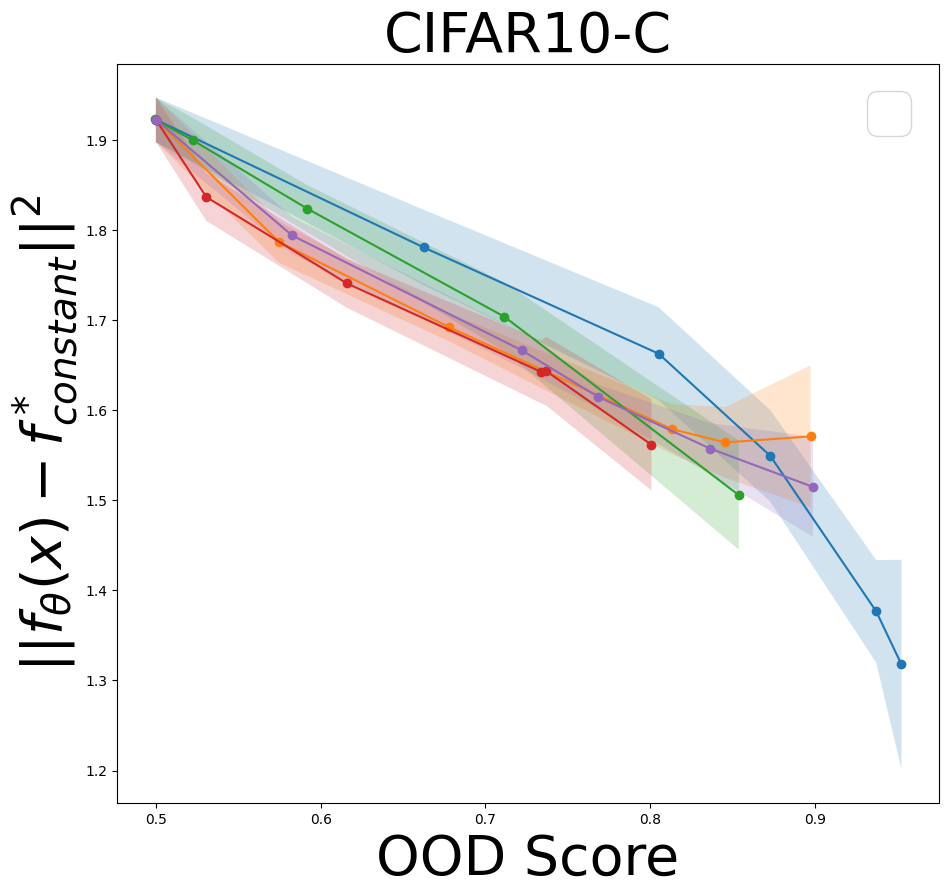

In [57]:
corruption_types = ["impulse_noise", "shot_noise", "defocus_blur", "motion_blur", "speckle_noise"]
corruption_type_labels = ["Impulse Noise", "Shot Noise", "Defocus Blur", "Motion Blur", "Speckle Noise"]

run_names = ["reward_prediction_seed0_2023_05_26_19_52_05",
            "reward_prediction_seed1_2023_05_26_19_52_26",
            "reward_prediction_seed2_2023_05_26_19_52_19", 
            "reward_prediction_seed3_2023_05_26_19_52_39", 
            "reward_prediction_seed4_2023_05_26_19_53_31", 
            "reward_prediction_seed5_2023_05_26_19_53_31"]

f_star = [-3.5 for _ in range(10)]
f_star.append(0)

plt.rcParams["figure.figsize"] = [2*5.3, 2*4.8]
plt.figure()
ax = plt.gca()
dir_path = os.path.dirname(os.path.abspath("__file__"))

for corruption_type_idx in range(len(corruption_types)):
    corruption_type = corruption_types[corruption_type_idx]
    dist_from_f_starts_all = []
    for run_name in run_names:
        with open(os.path.join(dir_path, "data", run_name, "outputs_"+corruption_type+'.pkl'), 'rb') as f:
            data = pickle.load(f)

        dist_from_f_starts = []
        for corruption_level in range(6):
            dist_from_f_start = ((data[corruption_level] - np.expand_dims(f_star, axis=0))**2).mean()
            dist_from_f_starts.append(dist_from_f_start)
        dist_from_f_starts_all.append(dist_from_f_starts)
    dist_from_f_starts_all = np.array(dist_from_f_starts_all)
    plt.fill_between(ood_scores_all[corruption_type], dist_from_f_starts_all.mean(axis=0)-dist_from_f_starts_all.std(axis=0), dist_from_f_starts_all.mean(axis=0)+dist_from_f_starts_all.std(axis=0), alpha=0.2)
    plt.plot(np.array(ood_scores_all[corruption_type]), dist_from_f_starts_all.mean(axis=0), "o-")

plt.xlabel("OOD Score", fontsize=40)
plt.ylabel("$||f_{\\theta}(x) - f^*_{constant}||^2$", fontsize=40)
plt.title("CIFAR10-C", fontsize=40)

plt.legend( fontsize=40)




